goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
from IPython.display import Audio

from math import floor

In [2]:
# find 50 random folders

base_dir = "../datasets/birdsongs-combined/train_audio/"

folders = os.listdir(base_dir)
folders = random.sample(folders, k=50)

rows = []

# load the entire file and split the data. (interval of 10 seconds?) (remove anything that is under 10 seconds long)
split_interval_secs = 2 # change this as you please. CAN be a float i think?

for i, folder in enumerate(folders):
    folder_dir = base_dir + folder + "/"

    for file in (progress_bar := tqdm(os.listdir(folder_dir))):
        # SET SAMPLE RATE TO 32000 FOR NOW. PREVENTS MULTIPLE STFT TRANSFORMS
        # duration might not need to be capped when using splits of X seconds
         # load AT MOST 2 minutes worth of data. purely for memory constraints. 90% of files are 2 mins or less so good cutoff point
        file_data, file_sample_rate_hz = librosa.load(folder_dir + file, sr=32000)

        total_splits = floor((len(file_data) / file_sample_rate_hz) / split_interval_secs) # floor(file length / split interval)

        #print(len(file_data) / file_sample_rate_hz, "seconds long", total_splits, "total splits")

        if total_splits >= 1:
            split_size = int(file_sample_rate_hz * split_interval_secs)

            for split_offset in range(0, file_sample_rate_hz * total_splits + 1, split_size):
                file_split_data = file_data[split_offset : split_offset + split_size]

                spec_data = np.abs(librosa.stft(file_split_data)) # convert file data into mel-spectrogram fourier transform for feeding into CNN

                row = [folder, file, len(file_split_data), file_sample_rate_hz, split_interval_secs, spec_data]
                rows.append(row)
            
        progress_bar.set_description(f"Folder {i + 1}/{len(folders)}* - {folder}")

    print(len(rows), "total rows")

    if len(rows) >= 1000: 
        print("Enumeration ended early due to having over 1000 files.")
        break

folder_df = pd.DataFrame(data=rows, columns=["folder", "file", "samples", "sample_rate_hz", "file_length_secs", "stft_data"])

del file, folders, file_data, file_sample_rate_hz, folder, i, folder_dir, progress_bar, row, rows, spec_data # conserve memory as much as possible

Folder 1/50* - pingro: 100%|██████████| 93/93 [00:18<00:00,  5.14it/s]


941 total rows


Folder 2/50* - oaktit: 100%|██████████| 107/107 [00:09<00:00, 11.38it/s]

2653 total rows
Enumeration ended early due to having over 1000 files.


<Axes: ylabel='Frequency'>

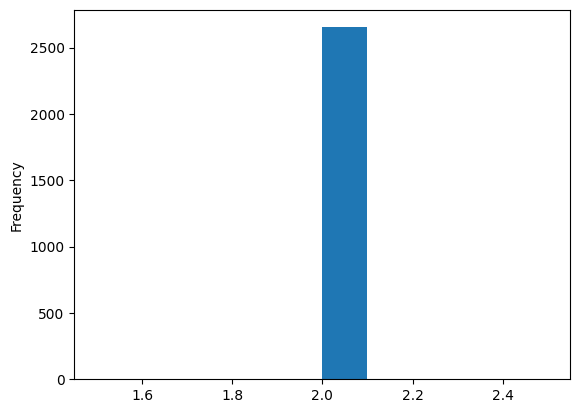

In [3]:
folder_df["file_length_secs"].plot.hist()

In [4]:
folder_df.sort_values(by="file_length_secs", ascending=False)

,folder,file,samples,sample_rate_hz,file_length_secs,stft_data
2652,oaktit,XC602846.ogg,64000,32000,2,"[[0.0094156815, 0.004906819, 9.347558e-05, 0.0..."
0,pingro,XC112634.mp3,64000,32000,2,"[[0.20521669, 0.068031035, 0.44863734, 0.06991..."
1,pingro,XC112635.mp3,64000,32000,2,"[[0.036542617, 0.049545325, 0.00011786874, 0.0..."
2,pingro,XC112635.mp3,64000,32000,2,"[[0.009674517, 0.12865853, 0.09637964, 0.04419..."
3,pingro,XC112635.mp3,64000,32000,2,"[[0.16528985, 0.18798073, 0.19075489, 0.161602..."
...,...,...,...,...,...,...
17,pingro,XC113479.mp3,64000,32000,2,"[[0.0023746197, 0.0011589275, 1.5070325e-05, 1..."
16,pingro,XC113479.mp3,64000,32000,2,"[[0.000870205, 0.0004027941, 2.078273e-05, 8.2..."
15,pingro,XC113479.mp3,64000,32000,2,"[[0.0007065855, 0.00034827107, 2.0386697e-05, ..."
14,pingro,XC113479.mp3,64000,32000,2,"[[0.0023332122, 0.0011284465, 6.636729e-05, 5...."


In [5]:
folder_df["folder"].value_counts()

folder
oaktit    1712
pingro     941
Name: count, dtype: int64

In [6]:
mel_specs = []
mel_spec_shapes = []

for i in tqdm(folder_df.index):
    row = folder_df.iloc[i, :]

    spec_magnitude, _ = librosa.magphase(row["stft_data"])
    mel_scale_spectrogram = librosa.feature.melspectrogram(S=spec_magnitude, sr=row["sample_rate_hz"])
    mel_scale_spectrogram_db = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)

    mel_specs.append(mel_scale_spectrogram_db)
    mel_spec_shapes.append(mel_scale_spectrogram_db.shape)

folder_df["mel_spec"] = mel_specs
folder_df["mel_spec_shape"] = mel_spec_shapes

del mel_specs, i, row, spec_magnitude, mel_scale_spectrogram, mel_scale_spectrogram_db, mel_spec_shapes

100%|██████████| 2653/2653 [00:07<00:00, 334.10it/s]


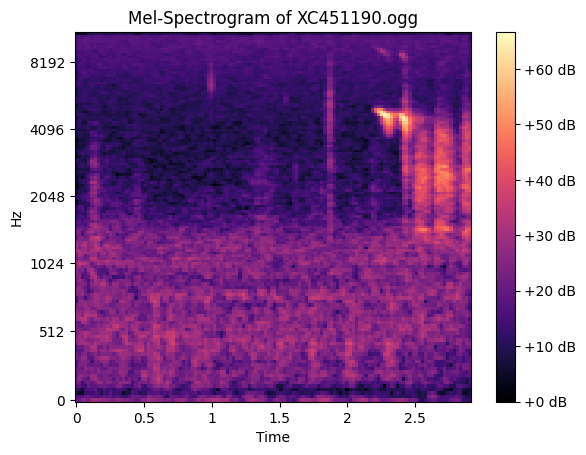

In [7]:
row = folder_df.iloc[random.randint(0, len(folder_df)), :]

plt.figure()
librosa.display.specshow(row["mel_spec"], x_axis="time", y_axis="mel")
plt.title(f"Mel-Spectrogram of {row["file"]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

del row

In [8]:
# mel_spec_shape's x value is ALWAYS 128.

In [9]:
folder_df[["file_length_secs", "mel_spec_shape"]].value_counts()

# all of the same shape WHEN:
# - all file lengths are the same (customise interval at will)
# - sample rate is controlled. (e.g. 32000hz)

# 10 second file length + 32000 sampling rate = (128, 626) input shape
# 2 second file length + 32000 sampling rate = (128, 126) input shape

file_length_secs  mel_spec_shape
2                 (128, 126)        2653
Name: count, dtype: int64

In [44]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)


# X = folder_df["mel_spec"]
# Y = folder_df["folder"]

x = folder_df["mel_spec"]
y = folder_df["folder"]

TypeError: array() missing required argument 'object' (pos 0)

In [11]:
# create machine learning model.

total_output_classes = len(folder_df["folder"].unique())

class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        # define layers here
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.act1 = nn.ReLU()

        self.output = nn.Linear(in_features=, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here

        # 128x126 -> 64x63 -> 32x31 -> 16x15 -> 8x7 -> 4x3 -> 2x1

        return x

SyntaxError: expected argument value expression (973580267.py, line 12)